In [2]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
! conda install -c rdkit rdkit -y 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-01-06 15:54:10--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   259MB/s    in 0.3s    

2021-01-06 15:54:11 (259 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [3]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
cd /content/drive/MyDrive/ML_2/project/

/content/drive/MyDrive/ML_2/project


In [8]:
df = pd.read_csv('250k_smiles.csv')
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(df["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(187091,)
(62364,)


In [10]:
charset = set("".join(list(df.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in df.smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'N', '2', 'l', '4', '\n', '5', 'r', 'n', ')', '6', 'o', 'S', '\\', 'P', 'H', ']', 'c', '(', 's', '7', 'C', '#', 'O', '+', '8', '@', 'I', '1', '-', 'B', '/', 'F', 'E', '[', '3', '!', '='}
37 115


Cc1cc(F)cc([C@H](N)C2([NH+](C)C)CCCC2)c1



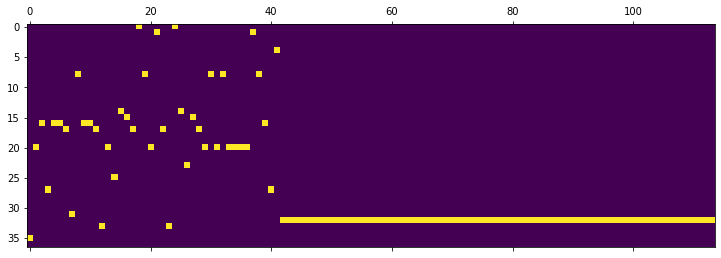

In [12]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print (smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [47]:
print (X_train.shape)

(187091, 114, 37)


In [13]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!Cc1cc(F)cc([C@H](N)C2([NH+](C)C)CCCC2)c1\nEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [22]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [16]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True,
                unroll=unroll)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = Concatenate(axis=-1)([state_h, state_c])
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states)

In [18]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 114, 37)]    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  26112       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128)          0           lstm_1[0][1]                     
                                                                 lstm_1[0][2]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        concatenate_1[0][0]          

In [19]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)


In [23]:
from keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

model.fit([X_train,X_train],Y_train,
                    epochs=200,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[X_test,Y_test])

Epoch 1/200
731/731 [==============================] - 18s 21ms/step - loss: 0.3633 - val_loss: 0.0000e+00
Epoch 2/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2984 - val_loss: 0.0000e+00
Epoch 3/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2807 - val_loss: 0.0000e+00
Epoch 4/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2709 - val_loss: 0.0000e+00
Epoch 5/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2643 - val_loss: 0.0000e+00
Epoch 6/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2612 - val_loss: 0.0000e+00
Epoch 7/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2570 - val_loss: 0.0000e+00
Epoch 8/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2533 - val_loss: 0.0000e+00
Epoch 9/200
731/731 [==============================] - 14s 19ms/step - loss: 0.2480 - val_loss: 0.0000e+00
Epoch 10/200
731/731 [===============

In [24]:
model.save('Lstm.h5')

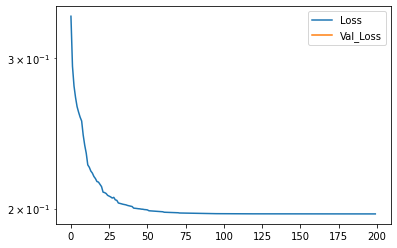

In [26]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

Encoder :

In [27]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)

smiles_to_latent_model.save("smi2lat.h5")

Decoder :

In [28]:
latent_input = Input(shape=(latent_dim,))
state_h_decoded_2 =  decode_h(latent_input)
state_c_decoded_2 =  decode_c(latent_input)
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("lat2state.h5")

### LSTM layer:

In [29]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)


In [30]:
for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("Mol_model.h5")
sample_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(1, 1, 37)]              0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 64)                26112     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 37)                2405      
Total params: 28,517
Trainable params: 28,517
Non-trainable params: 0
_________________________________________________________________


Latest space

In [31]:
x_latent = smiles_to_latent_model.predict(X_test)

### Creating molecules from latent space 

[    5 55207 59917 28317 33822 50798 20098 59383 48052 15992]
19753       CCC(CC)([C@@H](O)c1ccc(OC)cc1OC)[NH+](C)C\n
2103       CCC1CCC(O)([C@@]2(C[NH3+])CCOc3ccccc32)CC1\n
10929      CCCO[C@@H]1CCCN(c2ccc(S(N)(=O)=O)c(N)c2)C1\n
73320     CCC(=O)N1CCC(Cc2cc(NC3CCCC3)nc(C)[nH+]2)CC1\n
67465     CCC[NH2+][C@@H](c1ccc(F)cc1)C(C)(C)N1CCOCC1\n
193133      CCC[C@H](O)CNC(=O)NCc1cccc([N+]2=CCCC2)c1\n
67732         CCC(CC)[C@@H]([NH2+]C)[C@@H]1CN(CC)CCO1\n
60031      CCC[NH+]1CCC(N2CCN(c3cccc(C)[nH+]3)CC2)CC1\n
Name: smiles, dtype: object


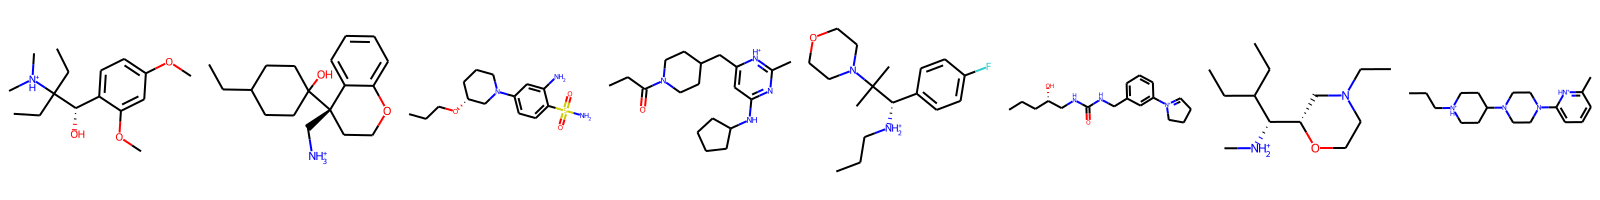

In [33]:
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))
print(sorti[0:10])
print(smiles_test.iloc[sorti[0:8]])
Draw.MolsToImage(smiles_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

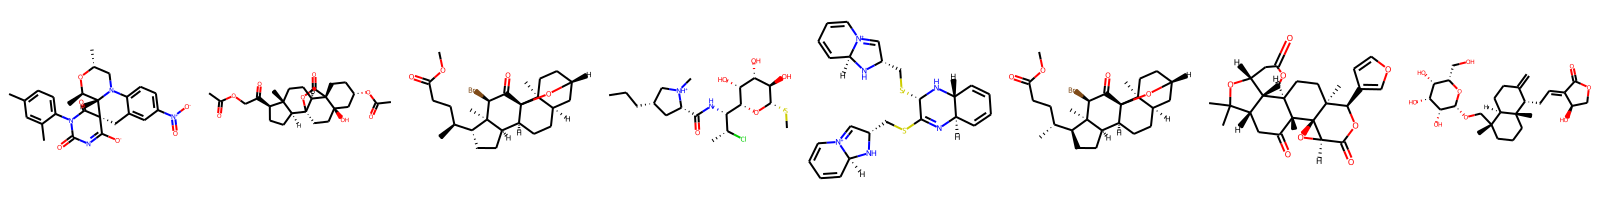

In [34]:
Draw.MolsToImage(smiles_test.iloc[sorti[-8:]].apply(Chem.MolFromSmiles))

### Plotting molecules in latent space : 

In [40]:

logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
from sklearn.decomposition import PCA


[0.5517475  0.39983413] 0.9515816


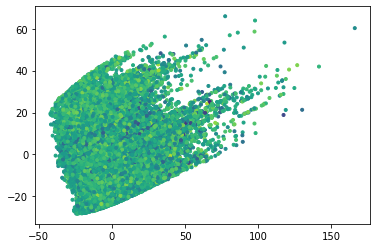

In [39]:
pca = PCA(n_components = 2)
red = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= logp)
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

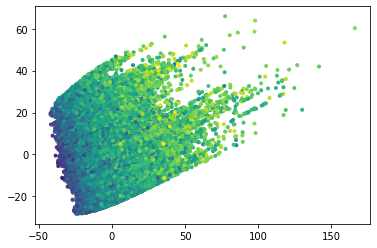

In [41]:
molwt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(red[:,0], red[:,1],marker='.', c= molwt)

### Interpolating between molecules 

In [59]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,37))
    samplevec[0,0,1] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(37):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,37))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

smiles = latent_to_smiles(x_latent[0:1])
 

In [60]:
print(smiles)
print(smiles_test.iloc[0])

C[NH+]1CCC[C@@H]1C(=O)NCC(=O)Nc1ccc(C
C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2=O)CC1



In [63]:
i = 0
j= 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0,1,25)
for r in ratios:
    rlatent = (1.0-r)*latent0 + r*latent1
    smiles  = latent_to_smiles(rlatent)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols1.append(mol)
    else:
        print(smiles)

C[NH+]1CCC[C@@H]1C(=O)NCC(=O)Nc1ccc(C
COCCn1c(C)cc(NC(=O)N[C@@H](C)c2ccc(C(
COC(=O)c1ccc(NC(=O)C(=O)N2CCC[C@@H](C
COc1ccc(N2CCN(C(=O)C(=O)Nc3ccc(C(C)C)
O=C(NC1CCCC1)[C@@H]1CCCN(C(=O)c2ccc(C
O=C(NC1CCCC1)[C@@H]1CCCN(C(=O)c2ccc(C
O=C(NCC1(c2ccccc2)CCCC1)N1CCN(C(=O)c2
O=C(CCC1CCCC1)N1CCC[C@@H](C(=O)N2CCC[
O=C(Cc1ccccc1)N1CCC[C@@H](C(=O)N2CCC[
O=c1[nH]c(C(=O)N2CCC[C@@H]2c2ccccc2)c
N#C[C@@H](NC(=O)c2ccccc2Cl)C1(Cl)C(=O
N#C[C@@H](c2ccccc2)N1C(=O)C[NH+]1CCC[
NC(=O)c1ccc(CNC(=O)N2CCC[C@@H]2c2ccc(
NC(=O)COc1ccc(C(=O)N2CCC[C@@H]2c2ccc(
Cc1noc(CNC(=O)[C@@H]2CCCN(C(=O)c3ccc(
Cc1n[nH]c1CCC(=O)N1CCC[C@@H](C(=O)Nc2
Cc1n[nH]c1CCC(=O)N1CCC[C@@H](C(=O)Nc2
Cc1nc(CCC(=O)NC[C@@H](C)C(=O)Nc2ccc(C
Cc1c(C(=O)NCCc3ccccc3)ccc2[C@H](C)N(C
Cc1cc(C)c(C(=O)NCCC[NH+](C)Cc3ccccc3)
Cc1cc(C(=O)Nc3ccc(C(=O)NCc4ccccc4)cc3
Cc1cc(C(=O)Nc3ccc(C(=O)NCc4ccccc4)cc3
Cc1cc([C@H](C(=O)Nc4ccc(Cl)cc4)CC3)c(
Cc1ccc(C(=O)C(C)(C)C(=O)N2CCN(C)Cc2cc
Cc1ccc(C(=O)C(C)(C)C(=O)N2CCN(C)C(=O)


In [64]:
len(smiles)

37

### Sample around latent space to find molecules that can be plotted 

In [67]:
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #TODO, try with
    smiles = latent_to_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)


C[NH+](CCC(=O)N1CCCC1)C(=O)N1CCC[C@@H
C[C@H](NC(=O)N[C@@H]1CCC[C@@H]1C(=O)[
C[NH+](C)CCNC(=O)N1CCC[C@@H](C(=O)Nc2
C[NH+]1CCC[C@@H]1C(=O)NCC(=O)Nc1ccc(C
C[C@H](NC(=O)N[C@@H]1CCC[C@@H]1C(=O)N
C[C@H](NC(=O)NC[C@@H]1CCCO1)c1ccc(C(=
C[NH+](C)CCNC(=O)N1CCC[C@@H](C(=O)Nc2
C[C@H](NC(=O)N[C@@H]1CCC[C@@H]1C(=O)[
C[NH+](CCC(=O)N1CCCC1)C(=O)N1CCC[C@@H
C[NH+](CCC(=O)N1CCCC1)C(=O)N1CCC[C@@H
C[NH+](CCC(=O)N1CCCC1)C(=O)N1CCC[C@@H
C[NH+](C)CCNC(=O)N1CCC[C@@H](C(=O)Nc2
C[C@H](NC(=O)N1CCC[C@H](C(=O)Nc2ccccc
C[C@H](NC(=O)N[C@@H]1CCC[C@@H]1C(=O)[
C[C@H](C(=O)N1CCCCC1)N1CCN(C(=O)c2ccc
C[C@H](NC(=O)NC[C@@H]1CCCO1)[C@@H]1CC
C[C@H](CC(=O)N1CCCCC1)[C@@H](C)[NH+]1
C[NH+](C)CCNC(=O)N1CCC[C@@H](C(=O)Nc2


In [68]:
mols

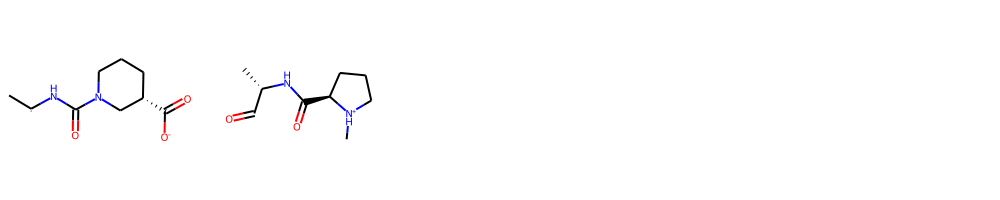

In [69]:
Draw.MolsToGridImage(mols, molsPerRow=5)